In [138]:
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import datetime as dt
import requests
import json
import base64
import hmac
import hashlib
import time
import asyncio
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [139]:
#from coinbase.wallet.client import Client
#public_client = cbpro.PublicClient()
import cbpro
public_client = cbpro.PublicClient()

In [140]:
""" loading the client's api keys and secret keys """
load_dotenv()
api_key = os.getenv("COINBASE_SAND_API")
api_secret = os.getenv("COINBASE_SAND_SECRET")
#api_passphrase = "columbia2021"
api_passphrase = os.getenv("COINBASE_SAND_PASSPHRASE")
#print(api_passphrase)
#print(api_secret)
#client = Client(api_key, api_secret, api_passphrase)


In [141]:
""" authorizing the api to interact with the sandbox"""

auth_client = cbpro.AuthenticatedClient(api_key, api_secret, api_passphrase,
                                  api_url="https://api-public.sandbox.pro.coinbase.com")

In [142]:
""" getting the client's sandbox wallet """

accounts = auth_client.get_accounts()
accounts

[{'id': '8316ad52-561d-442c-a53a-359c240cdcf6',
  'currency': 'BAT',
  'balance': '100000.0000000000000000',
  'hold': '0.0000000000000000',
  'available': '100000',
  'profile_id': '4e27f83d-522b-43e7-b3b7-fb8fc34dc43b',
  'trading_enabled': True},
 {'id': '67eda770-7b75-4688-841b-088fc34cd2ef',
  'currency': 'BTC',
  'balance': '99991.1283813900000000',
  'hold': '0.0000000000000000',
  'available': '99991.12838139',
  'profile_id': '4e27f83d-522b-43e7-b3b7-fb8fc34dc43b',
  'trading_enabled': True},
 {'id': '56ea24df-316b-4188-8a1f-44f3dad41bbb',
  'currency': 'ETH',
  'balance': '99998.5033469100000000',
  'hold': '0.0000000000000000',
  'available': '99998.50334691',
  'profile_id': '4e27f83d-522b-43e7-b3b7-fb8fc34dc43b',
  'trading_enabled': True},
 {'id': 'ef3bb19c-32a4-40c0-b6cb-25d0c23f052a',
  'currency': 'EUR',
  'balance': '0.0000000000000000',
  'hold': '0.0000000000000000',
  'available': '0',
  'profile_id': '4e27f83d-522b-43e7-b3b7-fb8fc34dc43b',
  'trading_enabled': Tru

In [143]:
public_client.get_product_order_book('BTC-USD')

{'bids': [['54794.17', '0.0626', 1]],
 'asks': [['54794.18', '0.48630396', 1]],
 'sequence': 30128298174,
 'auction_mode': False,
 'auction': None}

In [144]:
btc_ticker = public_client.get_product_ticker(product_id='BTC-USD')
#btc_ticker_df = pd.DataFrame(btc_ticker)

In [145]:
""" getting 24 hour stats """

btc_24hr = public_client.get_product_24hr_stats('BTC-USD')

btc_24hr_df = pd.DataFrame.from_dict(btc_24hr, 
    orient='index',dtype=None, #columns=None
)

#btc_24hr = btc_24hr.transpose().set_index('time')

btc_24hr_df


0
open                    56400
high                  56629.5
low                  53873.78
volume         15662.28286197
last                    54790
volume_30day  405819.28142831

In [146]:
""" getting the product ticker and time stamp """

btc = public_client.get_product_ticker('BTC-USD')

btc_df = pd.DataFrame.from_dict(btc,
    orient='index',dtype=None, #columns=None
)

btc_df

0
trade_id                    220719052
price                        54784.76
size                       0.00129968
time      2021-10-13T14:19:09.147181Z
bid                             54789
ask                          54789.01
volume                 15662.28286197

In [147]:
""" resetting the dataframe and time as index, dropping unneeded columns"""

btc_close = btc_df.transpose().set_index('time')

btc_close

trade_id     price        size    bid       ask  \
time                                                                            
2021-10-13T14:19:09.147181Z  220719052  54784.76  0.00129968  54789  54789.01   

                                     volume  
time                                         
2021-10-13T14:19:09.147181Z  15662.28286197

In [148]:
""" sell order btc to usd """

auth_client.sell(size='1', #BTC
               order_type='market',
               product_id='BTC-USD')

{'id': '4d800cde-ecb9-4e10-bf01-3b5fd912ace2',
 'size': '1',
 'product_id': 'BTC-USD',
 'side': 'sell',
 'stp': 'dc',
 'type': 'market',
 'post_only': False,
 'created_at': '2021-10-13T14:19:12.081783Z',
 'fill_fees': '0',
 'filled_size': '0',
 'executed_value': '0',
 'status': 'pending',
 'settled': False}

In [149]:
""" buy order btc from usd """
auth_client.buy(size='1', #BTC
               order_type='market',
               product_id='BTC-USD')

{'id': '78e79a79-a812-44fe-a968-8d376d532c99',
 'size': '1',
 'product_id': 'BTC-USD',
 'side': 'buy',
 'stp': 'dc',
 'funds': '649956.08840261',
 'type': 'market',
 'post_only': False,
 'created_at': '2021-10-13T14:19:12.246297Z',
 'fill_fees': '0',
 'filled_size': '0',
 'executed_value': '0',
 'status': 'pending',
 'settled': False}

next is setting the buy and sell signals

In [191]:
from Historic_Crypto import HistoricalData

btc_hist_data = HistoricalData('BTC-USD',3600,'2017-01-01-00-00').retrieve_data()

Checking input parameters are in the correct format...
Formatting Dates...
Checking if ticker supplied is available on the CoinBase Pro API...
Connected to the CoinBase Pro API...
Ticker 'BTC-USD' found at the CoinBase Pro API, continuing to extraction...
Data for chunk 0 of 139 extracted
Data for chunk 1 of 139 extracted
Data for chunk 2 of 139 extracted
Data for chunk 3 of 139 extracted
Data for chunk 4 of 139 extracted
Data for chunk 5 of 139 extracted
Data for chunk 6 of 139 extracted
Data for chunk 7 of 139 extracted
Data for chunk 8 of 139 extracted
Data for chunk 9 of 139 extracted
Data for chunk 10 of 139 extracted
Data for chunk 11 of 139 extracted
Data for chunk 12 of 139 extracted
Data for chunk 13 of 139 extracted
Data for chunk 14 of 139 extracted
Data for chunk 15 of 139 extracted
Data for chunk 16 of 139 extracted
Data for chunk 17 of 139 extracted
Data for chunk 18 of 139 extracted
Data for chunk 19 of 139 extracted
Data for chunk 20 of 139 extracted
Data for chunk 21 o

In [192]:
btc_hist_data

low      high      open     close      volume
time                                                                   
2017-01-01 01:00:00    968.21    972.00    970.99    970.49  148.353801
2017-01-01 02:00:00    967.00    971.99    970.49    967.95  108.436139
2017-01-01 03:00:00    967.57    969.47    967.83    968.14  125.094314
2017-01-01 04:00:00    966.64    968.62    968.17    968.10   79.411830
2017-01-01 05:00:00    964.37    968.10    968.10    966.92  159.864321
...                       ...       ...       ...       ...         ...
2021-10-13 10:00:00  54405.45  55200.00  54884.77  54660.29  581.867738
2021-10-13 11:00:00  54499.00  55245.12  54660.29  55212.33  647.562566
2021-10-13 12:00:00  54822.57  55345.68  55228.14  55040.55  577.225846
2021-10-13 13:00:00  54808.28  55241.67  55040.54  54911.12  741.072679
2021-10-13 14:00:00  54517.59  55775.14  54908.53  55775.14  806.661134

[41878 rows x 5 columns]

In [196]:
""" creating a signals dataframe to hold the values of the actual returns """


#btc_hist_data = btc_hist_data.loc[:, ["close"]]

btc_hist_data["Actual Returns"] = btc_hist_data["close"].pct_change()

btc_hist_data = btc_hist_data.dropna()

display(btc_hist_data.head())
display(btc_hist_data.tail())

low    high    open   close       volume  \
time                                                               
2017-01-06 07:00:00  981.28  988.50  983.31  983.06   208.522314   
2017-01-06 08:00:00  955.00  985.37  984.38  960.44   501.880720   
2017-01-06 09:00:00  904.71  969.14  960.50  933.26  1158.320120   
2017-01-06 10:00:00  910.00  944.18  933.26  926.61   558.749411   
2017-01-06 11:00:00  876.00  929.04  926.61  894.93  1101.963692   

                     Actual Returns  SMA_Fast    SMA_Slow  
time                                                       
2017-01-06 07:00:00       -0.000417   981.342  1029.04280  
2017-01-06 08:00:00       -0.023010   977.030  1028.98120  
2017-01-06 09:00:00       -0.028300   968.522  1028.70248  
2017-01-06 10:00:00       -0.007126   957.368  1028.38000  
2017-01-06 11:00:00       -0.034189   939.660  1027.78384

low      high      open     close      volume  \
time                                                                      
2021-10-13 10:00:00  54405.45  55200.00  54884.77  54660.29  581.867738   
2021-10-13 11:00:00  54499.00  55245.12  54660.29  55212.33  647.562566   
2021-10-13 12:00:00  54822.57  55345.68  55228.14  55040.55  577.225846   
2021-10-13 13:00:00  54808.28  55241.67  55040.54  54911.12  741.072679   
2021-10-13 14:00:00  54517.59  55775.14  54908.53  55775.14  806.661134   

                     Actual Returns   SMA_Fast     SMA_Slow  
time                                                         
2021-10-13 10:00:00       -0.004203  54827.460  55632.95352  
2021-10-13 11:00:00        0.010099  54797.926  55641.59016  
2021-10-13 12:00:00       -0.003111  54882.442  55643.26584  
2021-10-13 13:00:00       -0.002352  54943.052  55636.02784  
2021-10-13 14:00:00        0.015735  55119.886  55640.23864

In [194]:
btc_hist_data.to_csv('btc_hist_data_csv')

utc translation or conversion there should be a library utc conversioin

In [199]:
""" setting the rolling windows for the long and short positions"""
short_window = 5
long_window = 125

btc_hist_data['SMA_Fast'] = btc_hist_data['close'].rolling(window=short_window).mean()
btc_hist_data['SMA_Slow'] = btc_hist_data['close'].rolling(window=long_window).mean()

signals_df = btc_hist_data.dropna()

display(btc_hist_data.head())
display(btc_hist_data.tail())

low    high    open   close       volume  \
time                                                               
2017-01-11 11:00:00  835.00  874.97  872.81  846.92  1094.329668   
2017-01-11 12:00:00  788.88  846.88  846.88  815.76  1942.536255   
2017-01-11 13:00:00  792.58  828.00  815.76  822.04  1476.209713   
2017-01-11 14:00:00  800.00  825.66  822.01  811.96  1127.226343   
2017-01-11 15:00:00  802.80  824.64  811.91  805.02   918.379413   

                     Actual Returns  SMA_Fast  SMA_Slow  
time                                                     
2017-01-11 11:00:00       -0.029718       NaN       NaN  
2017-01-11 12:00:00       -0.036792       NaN       NaN  
2017-01-11 13:00:00        0.007698       NaN       NaN  
2017-01-11 14:00:00       -0.012262       NaN       NaN  
2017-01-11 15:00:00       -0.008547    820.34       NaN

low      high      open     close      volume  \
time                                                                      
2021-10-13 10:00:00  54405.45  55200.00  54884.77  54660.29  581.867738   
2021-10-13 11:00:00  54499.00  55245.12  54660.29  55212.33  647.562566   
2021-10-13 12:00:00  54822.57  55345.68  55228.14  55040.55  577.225846   
2021-10-13 13:00:00  54808.28  55241.67  55040.54  54911.12  741.072679   
2021-10-13 14:00:00  54517.59  55775.14  54908.53  55775.14  806.661134   

                     Actual Returns   SMA_Fast     SMA_Slow  
time                                                         
2021-10-13 10:00:00       -0.004203  54827.460  55632.95352  
2021-10-13 11:00:00        0.010099  54797.926  55641.59016  
2021-10-13 12:00:00       -0.003111  54882.442  55643.26584  
2021-10-13 13:00:00       -0.002352  54943.052  55636.02784  
2021-10-13 14:00:00        0.015735  55119.886  55640.23864

In [200]:
btc_hist_data['Signal'] = 0.0

btc_hist_data.loc[(btc_hist_data['Actual Returns'] >= 0), 'Signal'] = 1

btc_hist_data.loc[(btc_hist_data['Actual Returns'] < 0), 'Signal'] = -1

display(btc_hist_data.head())
display(btc_hist_data.tail())

low    high    open   close       volume  \
time                                                               
2017-01-11 11:00:00  835.00  874.97  872.81  846.92  1094.329668   
2017-01-11 12:00:00  788.88  846.88  846.88  815.76  1942.536255   
2017-01-11 13:00:00  792.58  828.00  815.76  822.04  1476.209713   
2017-01-11 14:00:00  800.00  825.66  822.01  811.96  1127.226343   
2017-01-11 15:00:00  802.80  824.64  811.91  805.02   918.379413   

                     Actual Returns  SMA_Fast  SMA_Slow  Signal  
time                                                             
2017-01-11 11:00:00       -0.029718       NaN       NaN    -1.0  
2017-01-11 12:00:00       -0.036792       NaN       NaN    -1.0  
2017-01-11 13:00:00        0.007698       NaN       NaN     1.0  
2017-01-11 14:00:00       -0.012262       NaN       NaN    -1.0  
2017-01-11 15:00:00       -0.008547    820.34       NaN    -1.0

low      high      open     close      volume  \
time                                                                      
2021-10-13 10:00:00  54405.45  55200.00  54884.77  54660.29  581.867738   
2021-10-13 11:00:00  54499.00  55245.12  54660.29  55212.33  647.562566   
2021-10-13 12:00:00  54822.57  55345.68  55228.14  55040.55  577.225846   
2021-10-13 13:00:00  54808.28  55241.67  55040.54  54911.12  741.072679   
2021-10-13 14:00:00  54517.59  55775.14  54908.53  55775.14  806.661134   

                     Actual Returns   SMA_Fast     SMA_Slow  Signal  
time                                                                 
2021-10-13 10:00:00       -0.004203  54827.460  55632.95352    -1.0  
2021-10-13 11:00:00        0.010099  54797.926  55641.59016     1.0  
2021-10-13 12:00:00       -0.003111  54882.442  55643.26584    -1.0  
2021-10-13 13:00:00       -0.002352  54943.052  55636.02784    -1.0  
2021-10-13 14:00:00        0.015735  55119.886  55640.23864     1.0

In [201]:
""" evaluating the balance of the signals"""
btc_hist_data['Signal'].value_counts()

 1.0    21520
-1.0    20108
Name: Signal, dtype: int64

In [202]:
""" creating a strategy returns colums to hold the returns data using the signals
programmed in the code
"""
btc_hist_data['Strategy Returns'] = btc_hist_data['Actual Returns'] * btc_hist_data['Signal'].shift()

display(btc_hist_data.head())
display(btc_hist_data.tail())

low    high    open   close       volume  \
time                                                               
2017-01-11 11:00:00  835.00  874.97  872.81  846.92  1094.329668   
2017-01-11 12:00:00  788.88  846.88  846.88  815.76  1942.536255   
2017-01-11 13:00:00  792.58  828.00  815.76  822.04  1476.209713   
2017-01-11 14:00:00  800.00  825.66  822.01  811.96  1127.226343   
2017-01-11 15:00:00  802.80  824.64  811.91  805.02   918.379413   

                     Actual Returns  SMA_Fast  SMA_Slow  Signal  \
time                                                              
2017-01-11 11:00:00       -0.029718       NaN       NaN    -1.0   
2017-01-11 12:00:00       -0.036792       NaN       NaN    -1.0   
2017-01-11 13:00:00        0.007698       NaN       NaN     1.0   
2017-01-11 14:00:00       -0.012262       NaN       NaN    -1.0   
2017-01-11 15:00:00       -0.008547    820.34       NaN    -1.0   

                     Strategy Returns  
time                                   
2017-01-11 11:00:00               NaN  
2017-01-11 12:00:00          0.036792  
2017-01-11 13:00:00         -0.007698  
2017-01-11 14:00:00         -0.012262  
2017-01-11 15:00:00          0.008547

low      high      open     close      volume  \
time                                                                      
2021-10-13 10:00:00  54405.45  55200.00  54884.77  54660.29  581.867738   
2021-10-13 11:00:00  54499.00  55245.12  54660.29  55212.33  647.562566   
2021-10-13 12:00:00  54822.57  55345.68  55228.14  55040.55  577.225846   
2021-10-13 13:00:00  54808.28  55241.67  55040.54  54911.12  741.072679   
2021-10-13 14:00:00  54517.59  55775.14  54908.53  55775.14  806.661134   

                     Actual Returns   SMA_Fast     SMA_Slow  Signal  \
time                                                                  
2021-10-13 10:00:00       -0.004203  54827.460  55632.95352    -1.0   
2021-10-13 11:00:00        0.010099  54797.926  55641.59016     1.0   
2021-10-13 12:00:00       -0.003111  54882.442  55643.26584    -1.0   
2021-10-13 13:00:00       -0.002352  54943.052  55636.02784    -1.0   
2021-10-13 14:00:00        0.015735  55119.886  55640.23864     1.0   

                     Strategy Returns  
time                                   
2021-10-13 10:00:00         -0.004203  
2021-10-13 11:00:00         -0.010099  
2021-10-13 12:00:00         -0.003111  
2021-10-13 13:00:00          0.002352  
2021-10-13 14:00:00         -0.015735

In [203]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x = btc_hist_data.index,
                                    open = signals_df['open'],
                                    high = signals_df['high'],
                                    low = signals_df['low'],
                                    close = signals_df['close'],
                                    ),
                     go.Scatter(x=btc_hist_data.index, y=btc_hist_data['SMA_Fast'], line=dict(color='purple', width=1)),
                     go.Scatter(x=btc_hist_data.index, y=btc_hist_data['SMA_Slow'], line=dict(color='green', width=1))])
                     #go.Scatter(x=signals_df.index, y=historical['SMA_Fast'], line=dict(color='green', width=1))])


fig.show()

<AxesSubplot:xlabel='time'>

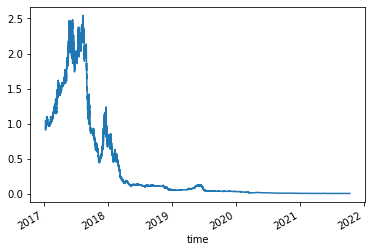

In [204]:
""" plotting the strategy returns to better see the data """

(1 + btc_hist_data['Strategy Returns']).cumprod().plot(x="date")

In [205]:
""" creating an X features dataframe to split the data into training and testing data"""

X = btc_hist_data[['SMA_Fast', 'SMA_Slow']].shift().dropna()


X.head()

SMA_Fast   SMA_Slow
time                                    
2017-01-16 16:00:00   831.948  817.50248
2017-01-16 17:00:00   833.112  817.39904
2017-01-16 18:00:00   834.016  817.54480
2017-01-16 19:00:00   833.844  817.63560
2017-01-16 20:00:00   834.120  817.81392

In [206]:
""" creating a y dataframe to hold the prediction data """

y = btc_hist_data['Signal']


y.value_counts()

 1.0    21520
-1.0    20108
Name: Signal, dtype: int64

In [207]:
""" telling the algorithm when to start the training data """
training_begin = X.index.min()

print(training_begin)

2017-01-16 16:00:00


In [208]:
""" telling the algorithm when to end the training data """
training_end = X.index.min() + DateOffset(years=4)

print(training_end)

2021-01-16 16:00:00


In [209]:
""" creating new training dataframes using the start/end data"""
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

display(X_train.head())
display(X_train.tail())

SMA_Fast   SMA_Slow
time                                    
2017-01-16 16:00:00   831.948  817.50248
2017-01-16 17:00:00   833.112  817.39904
2017-01-16 18:00:00   834.016  817.54480
2017-01-16 19:00:00   833.844  817.63560
2017-01-16 20:00:00   834.120  817.81392

SMA_Fast     SMA_Slow
time                                       
2021-01-16 12:00:00  37320.778  36057.51304
2021-01-16 13:00:00  37481.606  36081.95728
2021-01-16 14:00:00  37420.598  36095.86432
2021-01-16 15:00:00  37377.106  36107.79816
2021-01-16 16:00:00  37387.294  36124.67480

In [210]:
""" creating new testing dataframes using the start/end data"""
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

X_test.head()

SMA_Fast     SMA_Slow
time                                       
2021-01-16 17:00:00  37295.276  36149.59600
2021-01-16 18:00:00  37196.252  36171.14616
2021-01-16 19:00:00  37068.196  36201.75856
2021-01-16 20:00:00  36902.914  36226.86000
2021-01-16 21:00:00  36757.202  36268.81512

In [211]:
""" scaling the X data using StandardScaler instance """

scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [212]:
""" creating an SVM model to backtest the data """

svm_model = svm.SVC()
 
svm_model = svm_model.fit(X_train_scaled, y_train)
 
svm_pred = svm_model.predict(X_test_scaled)

svm_pred[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [213]:
""" creating a classification report to see the model's performance """
svm_testing_report = classification_report(y_test, svm_pred)


print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.49      0.16      0.24      3177
         1.0       0.51      0.85      0.64      3301

    accuracy                           0.51      6478
   macro avg       0.50      0.50      0.44      6478
weighted avg       0.50      0.51      0.44      6478



In [214]:
""" creating a new dataframe to hold the predictions of y using the X_test data 
We are using the actual and predicted returns to calculate the strategy returns
"""

predictions_df = pd.DataFrame(index=X_test.index)


predictions_df['Predicted'] = svm_pred


predictions_df['Actual Returns'] = signals_df['Actual Returns']


predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted']

display(predictions_df.head())
display(predictions_df.tail())

Predicted  Actual Returns  Strategy Returns
time                                                            
2021-01-16 17:00:00        1.0       -0.009029         -0.009029
2021-01-16 18:00:00        1.0       -0.010187         -0.010187
2021-01-16 19:00:00        1.0       -0.003229         -0.003229
2021-01-16 20:00:00        1.0        0.009462          0.009462
2021-01-16 21:00:00        1.0       -0.022330         -0.022330

Predicted  Actual Returns  Strategy Returns
time                                                            
2021-10-13 10:00:00        1.0       -0.004203         -0.004203
2021-10-13 11:00:00        1.0        0.010099          0.010099
2021-10-13 12:00:00        1.0       -0.003111         -0.003111
2021-10-13 13:00:00        1.0       -0.002352         -0.002352
2021-10-13 14:00:00        1.0        0.015735          0.015735

<AxesSubplot:xlabel='time'>

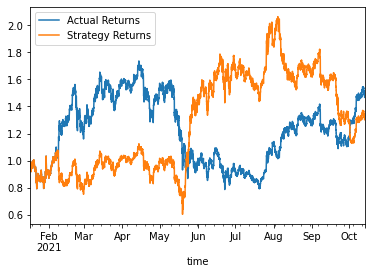

In [215]:
""" plotting the actual returns vs the strategy returns to analyse the performance of the model"""


(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()

In [216]:
# Import a new classifier from SKLearn
from sklearn.ensemble import AdaBoostClassifier

# Initiate the model instance
ada = AdaBoostClassifier()

In [217]:
""" fitting the training data to the new model to predict the y data using X_test_scaled"""
# Fit the model using the training data
ada_model = ada.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
y_pred = ada_model.predict(X_test_scaled)

# Review the model's predicted values
y_pred

array([-1., -1., -1., ..., -1., -1., -1.])

In [218]:
""" creating a classification report to see the model's performance"""
# Use a classification report to evaluate the model using the predictions and testing data
# Print the classification report
ada_training_report = classification_report(y_test, y_pred)

# Review the classification report
print(ada_training_report)

              precision    recall  f1-score   support

        -1.0       0.49      0.75      0.59      3177
         1.0       0.50      0.24      0.33      3301

    accuracy                           0.49      6478
   macro avg       0.49      0.50      0.46      6478
weighted avg       0.49      0.49      0.46      6478



In [219]:
""" creating a new dataframe to hold the predictions of y using the X_test data 
We are using the actual and predicted returns to calculate the strategy returns
"""
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_ada = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_ada['Predicted'] = y_pred

# Add the actual returns to the DataFrame
predictions_ada['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_ada['Strategy Returns'] = predictions_ada['Actual Returns'] * predictions_ada['Predicted']

# Review the DataFrame
display(predictions_ada.head())
display(predictions_ada.tail())

Predicted  Actual Returns  Strategy Returns
time                                                            
2021-01-16 17:00:00       -1.0       -0.009029          0.009029
2021-01-16 18:00:00       -1.0       -0.010187          0.010187
2021-01-16 19:00:00       -1.0       -0.003229          0.003229
2021-01-16 20:00:00       -1.0        0.009462         -0.009462
2021-01-16 21:00:00       -1.0       -0.022330          0.022330

Predicted  Actual Returns  Strategy Returns
time                                                            
2021-10-13 10:00:00       -1.0       -0.004203          0.004203
2021-10-13 11:00:00       -1.0        0.010099         -0.010099
2021-10-13 12:00:00       -1.0       -0.003111          0.003111
2021-10-13 13:00:00       -1.0       -0.002352          0.002352
2021-10-13 14:00:00       -1.0        0.015735         -0.015735

<AxesSubplot:xlabel='time'>

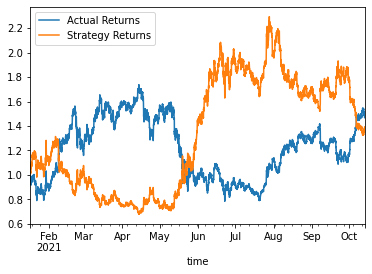

In [220]:
""" plotting the actual returns vs the strategy returns to analyse the performance of the model"""

# Plot the actual returns versus the strategy returns
(1 + predictions_ada[["Actual Returns", "Strategy Returns"]]).cumprod().plot()